Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing Required Libararies

In [3]:
!pip install dlib
!pip install fer

     |████████████████████████████████| 819kB 16.7MB/s 
     |████████████████████████████████| 2.3MB 52.6MB/s 


Changing the Current Directory

In [4]:
%cd /content/drive/MyDrive/face_recognition_application

/content/drive/MyDrive/face_recognition_application


Importing Libraries

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import csv
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, Lambda, AveragePooling2D, ZeroPadding2D, Activation, concatenate, MaxPool2D
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.externals import joblib
import math
import dlib
from fer import FER
from collections import deque, Counter
from mtcnn.mtcnn import MTCNN
from more_itertools import locate
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Instructions for updating:
non-resource variables are not supported in the long term


Loading FER 2013 Dataset for Emotion Recognition

In [ ]:
X = []   # list for storing images
Y = []   # list for storing the labels
with open('/content/drive/MyDrive/face_recognition_application/fer2013.csv', 'r') as f:
  reader = csv.reader(f)
  header = next(reader)
  for row in reader:
    label = int(row[0])
    img = row[1].split()
    image = np.array([int(a) for a in img], dtype='uint8')
    image = image.reshape((48, 48))
    image = np.expand_dims(image, axis=-1)
    X.append(image)
    Y.append(label)

print(len(X))
print(len(Y))

Splitting the Dataset into Train and Test Set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

32298
32298
3589
3589


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
X_train = X_train/255.0
X_test = X_test/255.0

(32298, 48, 48, 1)
(32298, 7)
(3589, 48, 48, 1)
(3589, 7)


Defining Model Architecture

In [ ]:
def fra_model(input_shape=(48, 48, 1)):
  r"""
  function: for defining model architecture
  param: input_shape - input shape of model
  return: compiled model
  """
  model = Sequential()
  model.add(Input(input_shape))
  model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv1'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv2'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv3'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv4'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.4))
  model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv5'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0), activation='relu', name='conv6'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(7, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))

  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = fra_model(input_shape=(48, 48, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 128)      

Training the Model

In [ ]:
aug = ImageDataGenerator(rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=False,
	fill_mode="nearest")
model.fit(aug.flow(X_train, Y_train, batch_size=32), batch_size=32, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
898/898 [==============================] - 33s 35ms/step - loss: 2.3320 - accuracy: 0.2032 - val_loss: 1.7331 - val_accuracy: 0.3089
Epoch 2/100
898/898 [==============================] - 31s 34ms/step - loss: 1.7138 - accuracy: 0.3187 - val_loss: 1.6401 - val_accuracy: 0.3950
Epoch 3/100
898/898 [==============================] - 31s 34ms/step - loss: 1.5514 - accuracy: 0.3937 - val_loss: 1.3567 - val_accuracy: 0.4696
Epoch 4/100
898/898 [==============================] - 31s 34ms/step - loss: 1.4469 - accuracy: 0.4427 - val_loss: 1.3521 - val_accuracy: 0.4855
Epoch 5/100
898/898 [==============================] - 31s 34ms/step - loss: 1.3810 - accuracy: 0.4739 - val_loss: 1.2256 - val_accuracy: 0.5364
Epoch 6/100
898/898 [==============================] - 31s 34ms/step - loss: 1.3334 - accuracy: 0.4910 - val_loss: 1.2613 - val_accuracy: 0.5215
Epoch 7/100
898/898 [==============================] - 31s 34ms/step - loss: 1.3019 - accuracy: 0.5009 - val_loss: 1.2072 - val_ac

Saving the Model

In [ ]:
model.save('/content/drive/MyDrive/face_recognition_application/fra_model1_7058_6850.h5')

CLassification Report 

In [ ]:
y_pred = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       980
           1       0.81      0.51      0.63       111
           2       0.60      0.42      0.49      1030
           3       0.90      0.87      0.88      1837
           4       0.57      0.56      0.57      1192
           5       0.76      0.81      0.79       821
           6       0.57      0.74      0.64      1207

    accuracy                           0.69      7178
   macro avg       0.69      0.65      0.66      7178
weighted avg       0.69      0.69      0.68      7178



Loading the Trained Facenet Model for Face Embeddings

In [ ]:
model_face = load_model('facenet_keras.h5')
model_face.summary()

05-04-2021:18:41:49,129 WARNING  [hdf5_format.py:193] No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Loading the Dataset for Face Recognition

In [ ]:
# If using the zip folder to extract images and labels
!mkdir 'Images'
!unzip 'Images.zip' -d 'Images'

In [ ]:
j = 1
x = []
y = []
data_dir = 'Images'
for folder in os.listdir(data_dir):
  print(folder)
  path1 = os.path.join(data_dir, folder)
  path = os.path.join(path1, 'frontal')
  for img in os.listdir(path):
      image = cv.imread(os.path.join(path, img))
      image = numpy.array(image, dtype='uint8')
      x.append(image)
      y.append(j)
  j += 1

In [ ]:
# if using the .npz file for extracting images and labels
data = np.load('/content/drive/MyDrive/face_recognition_application/images.npz', allow_pickle=True)
x = data['arr_0']
y = data['arr_1']
x = list(x)
y = y.tolist()

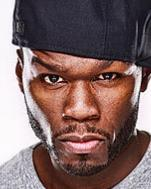

None


In [ ]:
print(cv2_imshow(x[0]))

In [ ]:
aug = ImageDataGenerator(
	zoom_range=0.01,
	width_shift_range=0.005,
	height_shift_range=0.005,
	shear_range=0.01,
  rotation_range=5,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

def augment(x_train, y_train):
  r"""
  function: for augmenting the dataset
  param: x_train - list of all images
         y_train - list of all labels
  return: x_final: list of augmented dataset
          y_final: list 
  """
  X_aug = []
  Y_aug = []
  class_ids = list(set(y_train))
  j = 0
  i = 1
  for j in range(0, 5010, 10):
    # c = y_train.count(i)
    # if c!=0:
    X_train = x_train[j: j+10]
    for img in X_train:
      img= np.expand_dims(img, axis=0)
      b = aug.flow(img)
      for j in range(1, 2):
        batch = b.next()
        a = batch[0].astype('uint8')
        # a = np.squeeze(a, axis=0)
        X_aug.append(a)
        Y_aug.append(i)
    i = i + 1
  
  
  x_final = x_train + X_aug
  y_final = y_train + Y_aug
  return x_final, y_final

In [ ]:
x_aug, y_aug = augment(x, y)

In [ ]:
print(len(x_aug))
print(len(y_aug))
print(set(y_aug))  # printing unique values/labels in the dataset

10020
10020
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

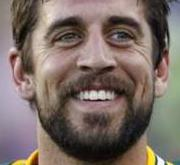

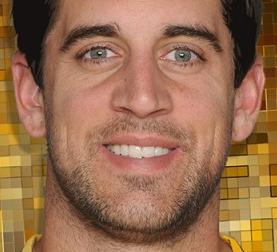

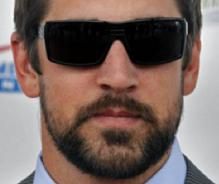

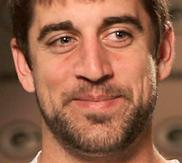

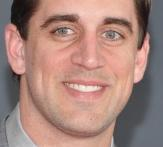

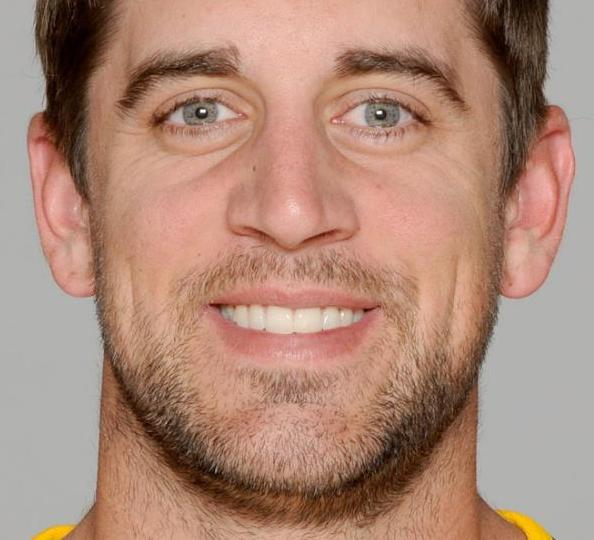

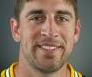

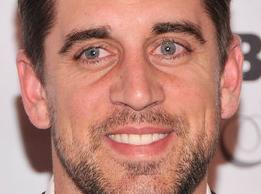

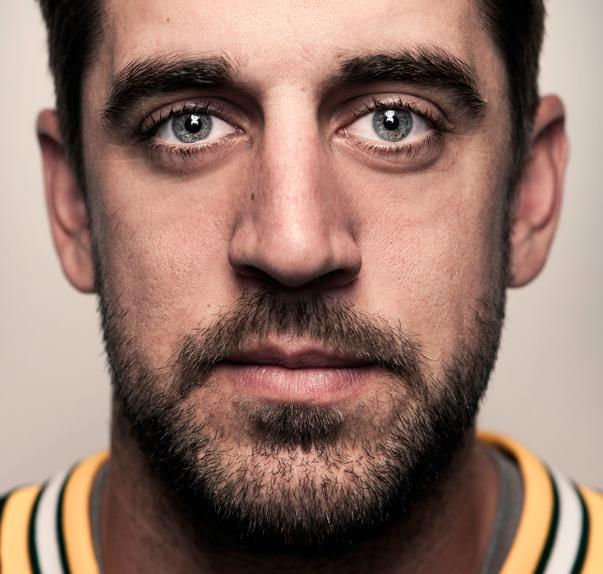

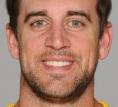

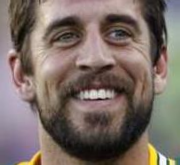

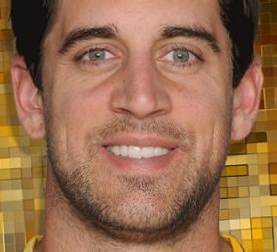

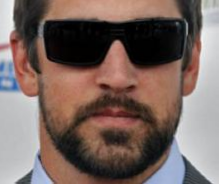

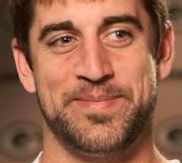

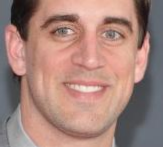

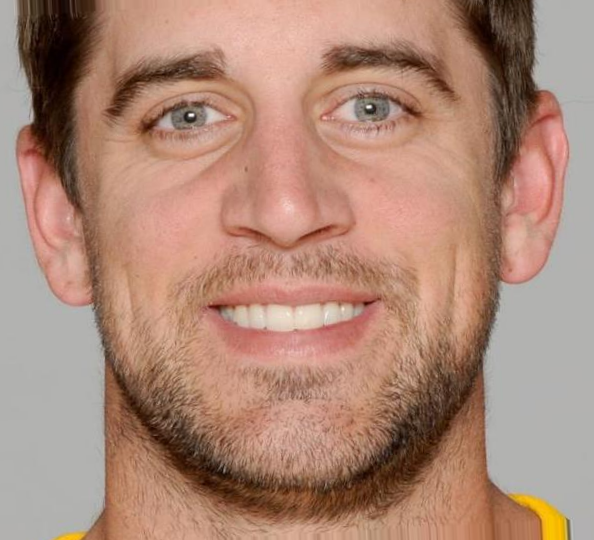

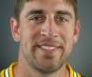

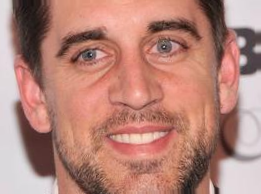

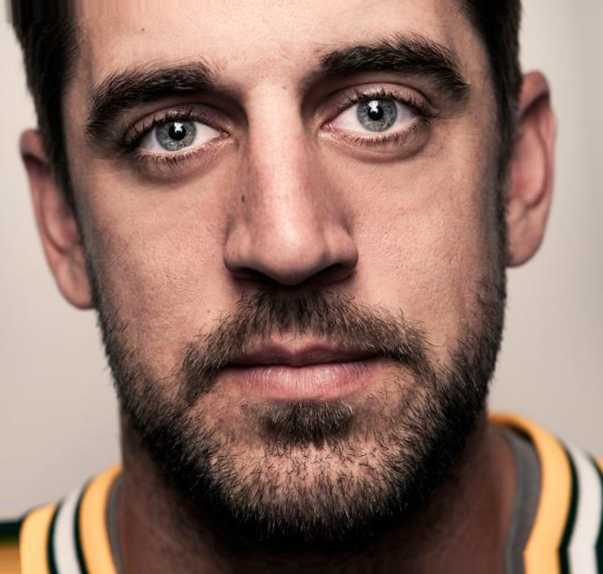

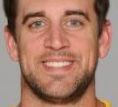

In [ ]:
# visulaizing images having a specific label
inxs = list(locate(y_aug, lambda c:c==3))
for inx in inxs:
  img = x_aug[inx]
  cv2_imshow(img)

Detecting Faces with MTCNN

In [ ]:
faces = []
y_final = []
face_detector = MTCNN()
for i, img in enumerate(x_aug):
  if y_aug[i]==501:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face = face_detector.detect_faces(rgb)
    if len(face)!=0:
      (X, Y, w, h) = face[0]['box']
      img = rgb[Y:Y+h, X:X+w]
      img = cv2.resize(img, (160, 160))
      f = np.array(img, dtype='uint8')
      faces.append(f)
      y_final.append(y_aug[i])
  else:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (160, 160))
    f = np.array(rgb, dtype='uint8')
    faces.append(f)
    y_final.append(y_aug[i])
print(len(faces))
print(len(y_final))
print(list(set(y_final)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10020
10020
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [ ]:
# printing number of images in each class
print(list(set(y_final)))
for j in range(1, 502):
  print(y_final.count(j))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

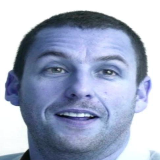

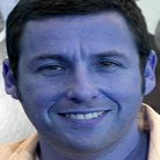

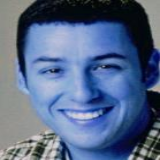

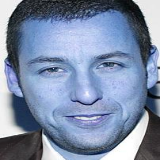

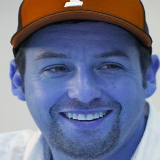

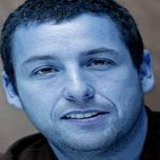

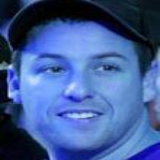

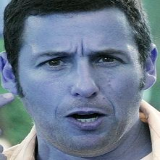

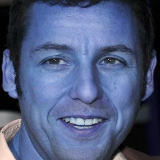

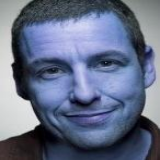

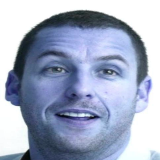

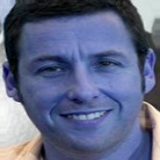

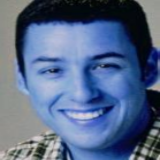

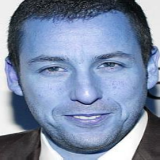

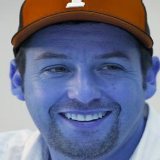

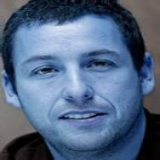

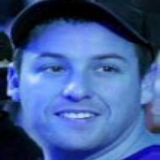

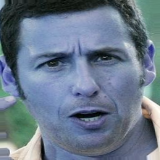

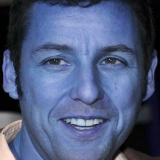

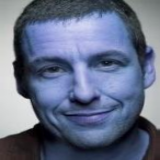

In [ ]:
# visulaizing images with specific label
inxs = list(locate(y_final, lambda c:c==6))
for inx in inxs:
  img = faces[inx]
  cv2_imshow(img)

Splitting Dataset into Train and Test Set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, y_final, test_size=0.1)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(list(set(y_train))))
print(len(list(set(y_test))))
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

9018
9018
1002
1002
501
435
(9018, 160, 160, 3)
(9018,)
(1002, 160, 160, 3)
(1002,)


Saving the Images of Faces and Labels

In [ ]:
np.savez_compressed('faces_cfp_aug.npz', x_train, y_train, x_test, y_test)

Getting the Embeddings of the Faces

In [6]:
def embeddings(model, img):
  r"""
  function: to calculate embeddings of images
  params: model - trained neural net model for embeddings extraction
          img - image for which embeddings needs to be calculated
  returns: embeddings for the image
  """
  image = img.astype('float32')
  mean = image.mean()
  stn = image.std()
  image = (image-mean)/stn
  image = np.expand_dims(image, axis=0)
  y_pred = model.predict(image)
  return y_pred

In [ ]:
# embeddings for images in train set
embeddings_cfp_train = []
for i in x_train:
  embedding = embeddings(model_face, i)
  embedding = embedding.reshape((128, ))
  embeddings_cfp_train.append(embedding)

print(len(embeddings_cfp_train))

9018


In [ ]:
# embeddings for images in train set
embeddings_cfp_test = []
for i in x_test:
  embedding = embeddings(model_face, i)
  embedding = embedding.reshape((128, ))
  embeddings_cfp_test.append(embedding)

print(len(embeddings_cfp_test))

1002


In [ ]:
embeddings_cfp_train = np.array(embeddings_cfp_train)
embeddings_cfp_test = np.array(embeddings_cfp_test)
print(embeddings_cfp_train.shape)
print(embeddings_cfp_test.shape)

(9018, 128)
(1002, 128)


Saving the Embeddings with Labels

In [ ]:
np.savez_compressed('embeddings_cfp_aug.npz', embeddings_cfp_train, y_train, embeddings_cfp_test, y_test)

Normalizing the Data

In [ ]:
# normalizing the data
in_encoder = Normalizer(norm='l2')
embeddings_cfp_train = in_encoder.transform(embeddings_cfp_train)
embeddings_cfp_test = in_encoder.transform(embeddings_cfp_test)

# encoding the labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

Training SVM classifier for Classifying the Embeddings

In [ ]:
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(embeddings_cfp_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Accuracies of the Model

In [ ]:
y_pred_train = model_svm.predict(embeddings_cfp_train)
score_train = accuracy_score(y_train, y_pred_train)

y_pred_test = model_svm.predict(embeddings_cfp_test)
score_test = accuracy_score(y_test, y_pred_test)

print(score_train*100)  # Accuracy of SVM Model on Train set
print(score_test*100)   # Accuracy of SVM Model on Test set

100.0
99.8003992015968


Classifiaction Report of the Model

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         1
          18       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saving the SVM Model

In [ ]:
joblib.dump(model_svm, 'svm_model_aug.pkl')

['svm_model_aug.pkl']

Loading the Names of People in Dataset

In [7]:
names = []
with open('list_name.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    names.append(line.strip())
print(len(names))

501


Age Predictor

In [8]:
def age_predictor(image_blob, age_model):
  r"""
  function: to predict the age of the person
  param: image_blob: blob of image on age prediction needs to be applied
         age_model: trained model through age prediction is done
  returns: prediction of the model on the image
  """
  age_model.setInput(image_blob)
  prediction_age = age_model.forward()[0]
  return prediction_age

Gender Predictor

In [9]:
def gender_predictor(image_blob, gender_model):
  r"""
  function: to predict the gender of the person
  param: image_blob: blob of image on age prediction needs to be applied
         gender_model: trained model through gender prediction is done
  returns: prediction of the model on the image
  """
  gender_model.setInput(image_blob)
  prediction_gender = gender_model.forward()[0]
  return prediction_gender

Emotion Predictor

In [10]:
def emotion_predictor(image, model, emotion_detector, f=False):
  r"""
  function: to predict the emotion shown by the person
  param: image: image on which emotion prediction needs to be applied
         model: trained model through emotion prediction is done
         emotion_detector: FER detector for emotion preditcion
         f: True/False based on whether to use FER or not for emotion detection
  returns: emotion prediction of the model on the image
  """
  if not f:
    emotion_list = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    image = cv2.resize(image, (48, 48))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = np.array(image_gray)
    image_gray = np.expand_dims(image_gray, axis=0)
    image_gray = np.expand_dims(image_gray, axis=-1)
    prediction_emotion = model.predict(image_gray)
    emotion = emotion_list[prediction_emotion[0].argmax()]
    return emotion
  else:
    if len(emotion_detector.detect_emotions(image))!=0:
      emotion, score = emotion_detector.top_emotion(image)
      print(emotion_detector.detect_emotions(image))
      return emotion
    else:
      emotion = 'neutral'
      return emotion

Face Landmark Detector

In [11]:
def align(img, coordinates):
  r"""
  function: for landmark detection on the face
  param: img: image on which landmark detection needs to be done
         coordinates: bounding box of face in the image
  returns: landmark points on the face
  """
  landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
  TEMPLATE = np.float32([
      (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
      (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
      (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
      (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
      (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
      (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
      (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
      (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
      (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
      (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
      (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
      (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
      (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
      (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
      (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
      (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
      (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
      (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
      (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
      (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
      (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
      (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
      (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
      (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
      (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
      (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
      (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
      (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
      (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
      (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
      (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
      (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
      (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
      (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

  TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
  MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)
  landmark_indices = [39, 42, 57]

  shape = landmark_predictor(img, coordinates)
  landmark = []
  for i in range(shape.num_parts):
      p = shape.part(i)
      landmark.append((p.x, p.y))
  return landmark

In [12]:
def face_recognizer(image):
  r"""
  function: to recognize the person in the image
  param: image: image on which face recognition needs to be done
  returns: prediction of the model on the image
  """
  image = cv2.resize(image, (160, 160))
  yhat = embeddings(model_face, image)
  yhat_norm = in_encoder.transform(yhat)
  ypred = svm_model.predict(yhat_norm)[0]
  # name = names[ypred]
  return ypred

Loading all the Necessary Models

In [13]:
model = load_model('fra_model1_7058_6850.h5')   # trained model for emotion prediction
model_face = load_model('facenet_keras.h5')     # trained Facenet Model for embedding extraction
emotion_detector = FER(mtcnn=True)              # FER model for emotion detection
face_detector = MTCNN()                         # MTCNN model for face detection
in_encoder = Normalizer(norm='l2')              # For normalizing data
svm_model = joblib.load('svm_model_aug.pkl')    # treained svm model face recognition/classification
age_network = cv2.dnn.readNet('deploy_age.prototxt', 'age_net.caffemodel')           # trained model for age prediction
gender_network = cv2.dnn.readNet('deploy_gender.prototxt','gender_net.caffemodel')   # trained model for gender prediction

06-04-2021:16:45:16,148 WARNING  [hdf5_format.py:193] No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Categories for Age and Gender Prediction

In [14]:
age_list = ['0-2', '4-6', '8-12', '15-20', '25-32', '38-43', '48-53', '60-100']  # categories for age
gender_list = ['male', 'female']  # categories for gender

In [54]:
def image_processing(image_path):
  r"""
  function: pipeline for all predictions on a single image
  param: image_path: path of the image where image is saved
  returns: processed image
  """
  image = cv2.imread(image_path)
  image = cv2.resize(image, (800, 800))
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  face_box = face_detector.detect_faces(image_rgb)
  for idx in range(len(face_box)):
    x1, y1, w1, h1 = face_box[idx]['box']
    print(face_box)
    if x1>=0 and y1>=0:
      face_roi = image[y1:y1+h1, x1:x1+w1, :]
      print(face_roi.shape)
      face_roi_emotion = face_roi.copy()

      image_blob = cv2.dnn.blobFromImage(face_roi, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), 
                                        swapRB=False)

      # gender prediction
      pred_gender = gender_predictor(image_blob, gender_network)
      gender = gender_list[pred_gender.argmax()]
      
      # age prediction
      pred_age = age_predictor(image_blob, age_network)
      age = age_list[pred_age.argmax()]

      # emotion prediction
      emotion = emotion_predictor(face_roi_emotion, model, emotion_detector, f=False)
      
      # face recognition
      name = names[face_recognizer(face_roi.copy())]
      print(name)

      # drawing bounding box and putting required text on image
      cv2.rectangle(image, (x1, y1), (x1+w1, y1+h1), (0, 0, 255), 2)
      cv2.putText(image, gender, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(image, age, (x1+w1-100, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(image, emotion, (x1, y1 + h1 + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(image, name, (x1+w1-120, y1+h1+30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(image, str(datetime.now()), (300, 770), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
  
  return image

[{'box': [258, 62, 231, 310], 'confidence': 0.9999995231628418, 'keypoints': {'left_eye': (322, 173), 'right_eye': (427, 176), 'nose': (377, 219), 'mouth_left': (323, 280), 'mouth_right': (427, 284)}}]
(310, 231, 3)
Zlatan Ibrahimovic


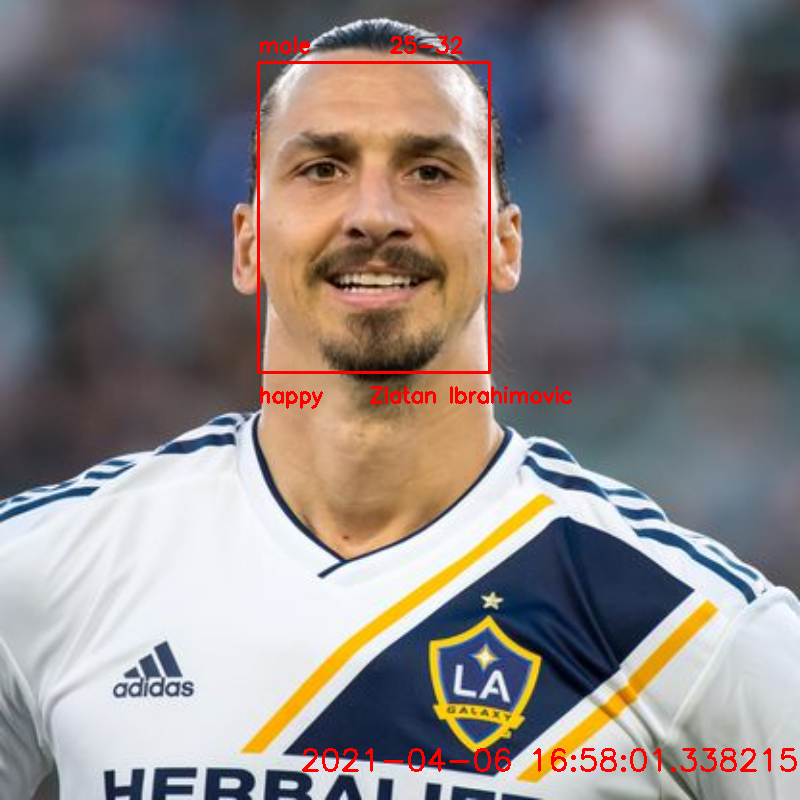

In [55]:
test_image = image_processing('/content/drive/MyDrive/face_recognition_application/zlatan_ibrahimovic.jpg')
cv2_imshow(test_image)

Processing Recorded Video for Face Detection, Age and Gender Prediction, Emotion Prediction and Face Recognition

In [57]:
cap = cv2.VideoCapture('video.avi')   # saved video
ret, frame = cap.read()
cap.set(3, 800)
cap.set(4, 800)
fourcc = cv2.VideoWriter_fourcc(*"XVID")
writer = cv2.VideoWriter('output.avi', fourcc, 30, (frame.shape[1], frame.shape[0]), True)  # output video writer

# Queue for Rolling Average Prediction for avoiding Flickering output in video
Q_age = deque(maxlen=16)
Q_gender = deque(maxlen=16)
Q_name = deque(maxlen=16)

while True:
  ret, frame = cap.read()
  if ret==False:
    cap.release()
    break
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  face = face_detector.detect_faces(rgb_img)
  for idx in range(len(face)):
    x, y, w, h = face[idx]['box']
    print(x, y, w, h)   # printing the bounding box of face

    if x>=0 and y>=0:

      roi = frame[y:y+h, x:x+w]
      roi_emotion = roi.copy()

      roi_blob = cv2.dnn.blobFromImage(roi, 1, (227, 227), (78.4263377603, 87.7689143744, 114.895847746), 
                                       swapRB=False)

      # gender prediction on current frame
      pred_gender = gender_predictor(roi_blob, gender_network)
      Q_gender.append(pred_gender)
      gender = gender_list[(np.array(Q_gender).mean(axis=0)).argmax()]
      
      # age prediction on current frame
      pred_age = age_predictor(roi_blob, age_network)
      Q_age.append(pred_age)
      age = age_list[(np.array(Q_age).mean(axis=0)).argmax()]

      # emotion prediction on current frame
      emotion = emotion_predictor(roi_emotion, model, emotion_detector, f=False)

      # face recognition on current frame
      roi_face = roi.copy()
      name_pred = face_recognizer(roi_face)
      Q_name.append(name_pred)
      list_Q_name = list(Q_name)
      count = Counter(list_Q_name)
      name = names[max(list_Q_name, key=count.get)]

      # drawing bounding box and putting required text on current frame
      cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
      cv2.putText(frame, gender, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(frame, age, (x+w-100, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(frame, emotion, (x, y + h + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(frame, name, (x+w-120, y+h+30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
      cv2.putText(frame, str(datetime.now()), (300, 770), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

  writer.write(frame)  # writing processed frame to output video

cv2.destroyAllWindows()

298 97 141 184
411 405 84 94
298 96 141 184
405 396 91 107
300 99 138 180
297 96 141 183
295 98 141 183
296 102 140 178
298 102 139 177
295 103 141 182
292 102 143 182
294 109 142 177
292 111 141 175
289 105 141 181
287 110 142 177
284 109 143 178
286 104 143 185
285 104 142 182
285 109 140 180
285 108 141 180
285 103 144 184
285 103 143 183
285 111 143 180
287 107 142 182
288 107 140 180
285 109 143 183
289 105 142 183
289 104 141 185
289 104 142 184
286 102 144 186
285 101 145 187
285 101 145 186
280 102 149 188
285 100 145 186
288 109 144 180
287 103 145 186
286 111 145 180
287 102 144 183
285 93 149 196
287 93 147 195
287 103 144 184
287 103 144 184
288 103 142 185
287 111 145 180
288 101 142 183
287 101 144 185
286 106 145 183
287 108 144 181
287 105 144 182
288 103 143 183
286 102 145 184
286 102 145 184
287 101 145 183
285 106 144 184
285 109 146 182
287 109 142 179
286 103 145 184
286 107 144 183
287 109 143 181
289 105 140 184
286 104 144 186
288 104 142 182
288 104 141 182
28